In [16]:
import kplr
from astropy.io import fits as pyfits
import scipy
from scipy import signal
import astropy
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import time as ptime
import operator
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [17]:
n = 8
file = "cumulative.csv"
final = 0
print("Getting KOIs...")
client = kplr.API()
# Gets false positive KOIs from csv where KOIs are in the second column
IDs = np.genfromtxt(file, dtype=str, usecols = 1, skip_header = 12, unpack= True, delimiter = ',') #.astype(str)
IDs = IDs.tolist()
kois = np.zeros(n, object)
for i in range(n): 
    koi = float(IDs[i + final][1:])
    kois[i] = client.koi(koi)
    print("Reading %d..." % i)
periods = np.zeros(n)
lcss = np.zeros(n, object)
durations = np.zeros(n)
centroids = np.zeros(n)
stars = np.zeros(n, object)
for i in range(n):
    periods[i] = kois[i].koi_period
    lcss[i] = np.array(kois[i].get_light_curves(), dtype=object)
    durations[i] = kois[i].koi_duration
    centroids[i] = kois[i].koi_time0bk
    stars[i] = np.array(kois[i].star, dtype=object)

Getting KOIs...
Reading 0...
Reading 1...
Reading 2...
Reading 3...
Reading 4...
Reading 5...
Reading 6...
Reading 7...


In [18]:
koi = kois[0]
lcs = lcss[0]
period = periods[0]
duration = durations[0]
centroid = centroids[0]
star = stars[0]

In [19]:
print("Formatting light curve...")
# Loop over the datasets and read in the data.
time, flux = [], []
for lc in lcs:
    with lc.open() as f:
        hdu_data = f[1].data
        time = time + hdu_data["time"].tolist()
        flux = flux + hdu_data["pdcsap_flux"].tolist()
    lightcurve = pd.DataFrame({"time": time, "flux" : flux})
    lightcurve = lightcurve.dropna()
median = lightcurve['flux'].median()
lightcurve['time'] = lightcurve['time'].mod(period)
lightcurve['flux'] = lightcurve['flux'].apply(lambda x: x/median)
angular_frequency = (2*np.pi)/period
lightcurve['time'] = lightcurve.multiply(angular_frequency, axis = 'time')
centroid = np.mod(centroid, period)*angular_frequency
shift = np.pi - centroid
centroid = centroid + shift
print(shift)
if shift>0:
    lightcurve['time'] = lightcurve['time'].apply(lambda x: x + shift)
    lightcurve['time'] = lightcurve['time'].apply(lambda x: x - 2*np.pi if x>2*np.pi else x)
elif shift<0:
    lightcurve['time'] = lightcurve['time'].apply(lambda x: x + shift)
    lightcurve['time'] = lightcurve['time'].apply(lambda x: x + 2*np.pi if x<0 else x)
lightcurve = lightcurve.sort_values(by=['time'])

Formatting light curve...
1.443743770528102


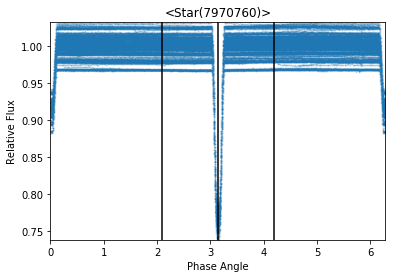

In [20]:
fig, ax = plt.subplots()
ax.scatter(lightcurve.time, lightcurve.flux, alpha = 0.2, s = 0.8)
ax.vlines([np.pi, 2*np.pi/3, 4*np.pi/3], min(lightcurve.flux), max(lightcurve.flux))
ax.set_title(str(koi.star))
ax.set_xlabel("Phase Angle")
ax.set_ylabel("Relative Flux")
ax.set_xlim([min(lightcurve.time), max(lightcurve.time)])
ax.set_ylim([min(lightcurve.flux), max(lightcurve.flux)])
plt.show()

0.8213944496270612
0.2248344844857306


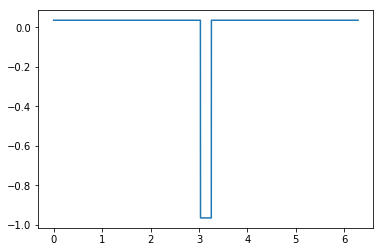

In [21]:
print(angular_frequency)
transit_duration = angular_frequency*(duration/24)
print(transit_duration)
transit_start = centroid - transit_duration/2
transit_end = centroid + transit_duration/2
'''
for i in range(len(time)-1):
    if (time[i] <= transit_start) and (time[i+1] >=transit_start):
        t1 = i
    elif (time[i] <= transit_end) and (time[i+1] >=transit_end):
        t2 = i

t1 = lightcurve[lightcurve.time == lightcurve.time[lightcurve.time < transit_start].max()]
t2 = lightcurve[lightcurve.time == lightcurve.time[lightcurve.time > transit_start].min()]
'''
time = lightcurve['time'].values
flux = lightcurve['flux'].values
filter_centroid = np.pi
filter_width = transit_duration
transit_height = (1-min(lightcurve.flux[t1:t2]))
filter = np.full(3*len(lightcurve), transit_duration/(2*np.pi))
for i in range(len(time)):
    if (time[i] > filter_centroid - filter_width/2) and (time[i] < filter_centroid + filter_width/2):
        filter[i + len(time)] = transit_duration/(2*np.pi)-1
plt.plot(time, filter[len(time):2*len(time)])
plt.show()

In [22]:
DV = 3
hop_size = filter_length//DV
n_hops = ((len(flux)-filter_length)//hop_size)
print(n_hops) 
product = np.zeros(n_hops)
for i in range(n_hops):
    slice = filter[(i*hop_size):(i*hop_size)+filter_length]
    product[i] = np.dot(slice, filter)
plt.plot(product)
plt.show()

39


ValueError: shapes (4644,) and (195789,) not aligned: 4644 (dim 0) != 195789 (dim 0)